# Intro to ML for EEB, session 2

Hello! This notebook demonstrates how to make a classifier to distinguish between penguin species.

This notebook will be in Python, which some of you may be unfamiliar with. In my opinion, the limiting factor in data analysis and ML is asking the right questions: ***what*** questions should you ask about your data to better understand it? 

***How*** to do it is another issue, but going in a good direction in the first place is the most important (so having a good advisor is nice :) ). Once you have a good direction, nowadays we can just use AI to code with us so that we don't need to remember a bunch of syntax, but we do need to double check everything.

Once you've defined ***what*** to do, most coding lanuages these days allow you to do everything the other language can. Popularity can make a language nicer to know, since you have more code to use from other people.

I'll try to explain how the code works, and if my explanations don't make sense, I find chatGPT gives very good explanations of code snippets (regardless of the language).

This notebook will illustrate a typical machine learning (ML) workflow, where we will use 2 different base ML models: logistic regression and decision trees. We will unfortunately not use neural networks, because the data we'll analyze is too simple, and simple approaches perform quite well already!


In [131]:
# it's common practice, but not required, to import all packages you'll use at the top of a file

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
#!pip install palmerpenguins
from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Initialize a few things

Colors to use for plotting, 1 for each species.

In [132]:
# colors selected from https://coolors.co/palettes/trending
pal = ["#219ebc", "#fb8500", "#023047"] # 3 for the 3 species


Select species to analyze.

Today we'll only distinguish between two species to keep things simple, although I originally wrote this workshop to distinguish between all 3: Adelie, Gentoo, and Chinstrapp.

In [133]:
species_to_analyze = ['Adelie',  'Gentoo']

# a sanity check to prevent everything downstream from breaking :)
assert len(species_to_analyze) > 1, "You need to select more than one species to analyze!"


### Select difficulty

Let's start out easy, but set this variable to True later and see what happens.

In [134]:
hard_mode = False

## About the penguin data
See [here](https://allisonhorst.github.io/palmerpenguins/) for a description of the data and the features we'll use. 

Machine learning (ML) involves building a model to predict a response using other features that we've measured. 

These features must have some *informative* relationship with the response: as a feature changes values, so does the response. 


Since today's data are relatively simple, we can visualize the relationship between the features and the response with plots! Intuitively, if we're trying to distinguish between species, they should have systematic differences in 1 or more features!

ADVANCED NOTE: in practice, we may have measured *many* features, only some are informative, and we aren't sure which ones. Many ML algorithms can perform *feature selection* in which they find the informative features and only use those. Today, we have preselected informative features.

## Load dataset into a "pandas DataFrame"

A 'DataFrame' is a simple way to represent data with rows and columns. It's similar to what you'd see in R, but the commands you use to manipulate/access it are different because it's Python.

In [135]:
# load in the data we downloaded with the 'palmerpenguins' package
penguins = load_penguins()

# INSPECT DataFrame
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


### Clean data

All of this is done in one code cell, where the functions are all run back-to-back. In practice, this usually involves a trial-and-error process where we realize we need to process the data in different ways, but I put all these functions in one code cell to make this clean and modular.

In [136]:
# ADD COLUMN that assigns each species a color, useful to make colors consistent across plots
# this is NOT a necessary step, I just wanted things to looks pretty and consistent
penguins["color"] = penguins["species"].map({"Adelie": pal[0], 
                                             "Gentoo": pal[1],
                                             "Chinstrap": pal[2]})

# EXCLUDE ROWS with missing data 
# we only exclude rows where there is missing data for any of the variables listed in the subset argument, which we give a list of names
penguins = penguins.dropna(subset = ["bill_length_mm", 
                                     "bill_depth_mm", 
                                     "species", 
                                     "flipper_length_mm", 
                                     "body_mass_g"])

# SELECT ROWS containing the species of interest, specified above
penguins = penguins.loc[penguins['species'].isin(species_to_analyze)]

# RESET INDEX, since some rows may have been eliminated from selecting species
penguins.reset_index(drop=True, inplace=True)

# fraudulently manipulate data to demonstrate ML with messier signals
if hard_mode == True:
    penguins['bill_length_mm'] = np.where(penguins['species'] == 'Adelie', 
                                          penguins['bill_length_mm']+4, 
                                          penguins['bill_length_mm'])
    penguins['bill_depth_mm'] = np.where(penguins['species'] == 'Adelie', 
                                          penguins['bill_depth_mm']-3, 
                                          penguins['bill_depth_mm'])



Above, it looked like these species are distributed among several islands and collected across several years.

What do these categorical variables look like?

In [137]:
penguins['species'].unique()

array(['Adelie', 'Gentoo'], dtype=object)

In [138]:
penguins['year'].unique()

array([2007, 2008, 2009])

In [139]:
penguins['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

### Plot features to assess relationship with response (species)

Here, we will use the seaborn 'pairplot' function, which produces a lot of info, a martix of plots. At first I made some plots using some data wrangling along with some other plotting functions, but my AI bot (github copilot) proposed this one line solution that made code much simpler.

We will tell pairplot to color the data by species using the 'hue' argument, and we will select only some of the columns form the DataFrame (ignoring the 'year').

<Figure size 500x500 with 0 Axes>

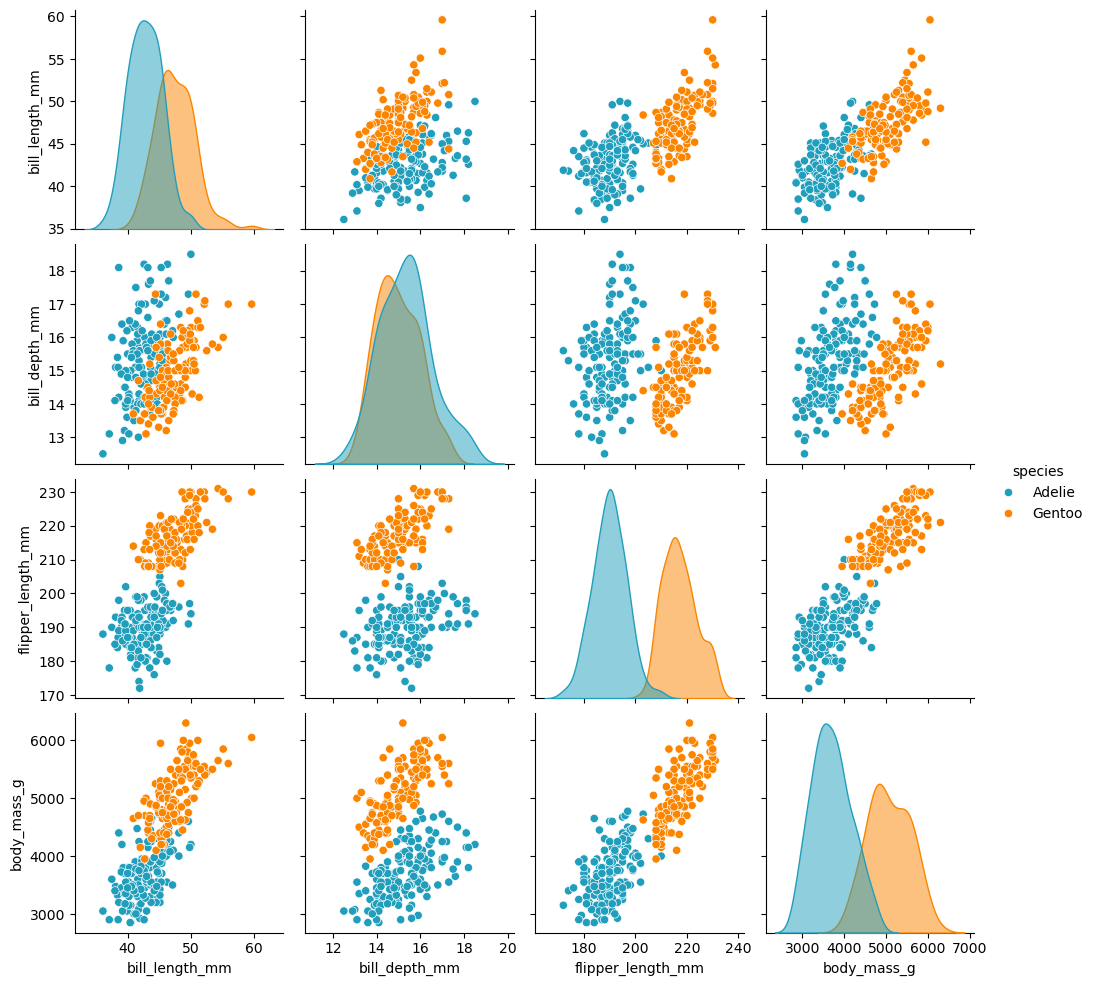

In [140]:
plt.figure(figsize=(5, 5))
sns.pairplot(penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'species']], 
             hue="species", palette=pal[0:2], diag_kind="kde", diag_kws=dict( alpha=0.5, linewidth=1))


This figure compares features in a pairwise fashion. 

The diagonals are comparing a feature with itself, so it just plots a histogram of the feature.

In the off-diagonals, it's comparing features in a pairwise fashion using a scatterplot.

One interesting thing that immediately emerges from this is that the species seem to differ according to all these features, but there's always some overlap (digonal plots).

However, when you look at any two of these features simultaneously (off-diagonal plots), the two species are **highly** separable, so using multiple features can be powerful. ML algorithms will see this huge difference in two dimensions, and make a 'decision boundary' right between the cleanly separated species. If data are on one side of the decision boundary, they get classified as species 1, if they're on the other side, species 2

Thought: body mass can vary depending on sex. Are sex ratios of these samples very different between species? Specifically, is body mass generally greater in one species because we've systematically sampled more males from that species?

In [141]:
# select the 'species' and 'sex' columns, group the values by 'species' species, and count the sex
penguins[['species', 'sex']].groupby('species').value_counts()

species  sex   
Adelie   female    73
         male      73
Gentoo   male      61
         female    58
Name: count, dtype: int64

Let's proceed with the bill features.

While we've manually gone through our dataset to get an intuition of the relationship between the features and response, this can be tedious if we've measured thousands of features. In these cases, there are approaches to automate this and select the best features.

Let's store our data in more informatively-named tables: `features` as `X`, and `response` as `Y`

In [142]:
# feel free to add more features!
X = penguins[["bill_length_mm", "bill_depth_mm"]]
Y = penguins["species"]

## Split data into 2 parts: training and testing
Again, we could do this ourselves by randomly sampling penguins from our data, but scikit-learn has a `train_test_split` function to do this for us. Specify what fraction of the data you want to use as the test set using the `test_size` argument.

In [143]:
# we also set the random_state to ensure we all get the same results!
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.3, 
                                                    random_state=11, 
                                                    shuffle=True)

# plot the 'shape' or 'dimensions' of the data (or number of rows and columns if matrix is 2D)
print("X_normalized dimensions ", X.shape)
print("X_train dimensions ", X_train.shape)
print("X_test dimensions ", X_test.shape)

X_normalized dimensions  (274, 2)
X_train dimensions  (191, 2)
X_test dimensions  (83, 2)


Let's just quick peek at the training data

In [144]:
X_train

,bill_length_mm,bill_depth_mm
128,48.1,15.0
0,43.1,15.7
112,46.2,16.5
122,45.4,15.5
157,45.4,14.6
...,...,...
161,40.9,13.7
269,47.2,13.7
91,38.0,14.1
80,46.9,14.6


In [145]:
Y_train

128    Adelie
0      Adelie
112    Adelie
122    Adelie
157    Gentoo
        ...  
161    Gentoo
269    Gentoo
91     Adelie
80     Adelie
191    Gentoo
Name: species, Length: 191, dtype: object

## Feature rescaling

It's best practice to **rescale** our features so that they all have similar values and ranges. Not doing so can lead to models with bad predictive performance!

 Here we will use a function from scikit learn that performs 'z-score normalization': for each feature, we will take it's value, subtract the mean, and divide by the standard deviation. This makes all features have a mean of 0 with standard deviation of 1.

 $$ z = {x - \mu_x \over \sigma_x} $$

We could do this normalization ourselves, but the scikit-learn package has several functions to normalize your data, so let's use these. I always try to write as little new code as possible, to keep my code as simple, clean, and bug-free as possible.


Lastly, let's make a plot of the features before and after. Sanity checks are **always** a good idea.

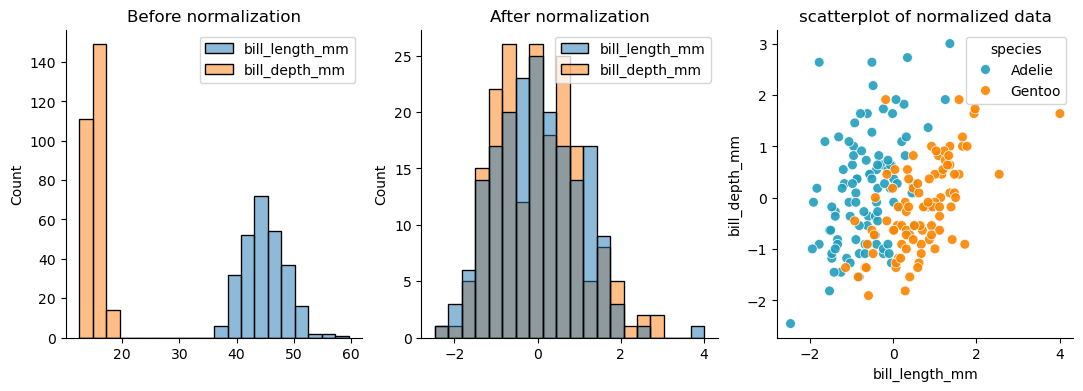

In [146]:
# Initiate the scaler, and have it output the data as a pandas DataFrame, for ease of use
scaler = StandardScaler().set_output(transform="pandas")
# Fit the scaler to the training data, i.e. compute the mean and std for the training data
scaler.fit(X_train)

# transform the training and test data, here the test data was transformed using prior information from the training data (mean and variance)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# plot the features before and after rescaling

#specify plot layout and size
fig, axs = plt.subplots(1, 3, figsize=(13, 4))

# plot histogram of original features
sns.histplot(X, bins=20, ax=axs[0])
axs[0].set_title("Before normalization")

# plot histogram of TRANSFORMED features
sns.histplot(X_train, bins=20, ax=axs[1])
axs[1].set_title("After normalization")

# make scatterplot to verify that between-species differences remain after you've transformed the data
sns.scatterplot(data=X_train, x="bill_length_mm", y="bill_depth_mm", hue=Y, palette = pal[0:2], alpha=0.9, s=50, ax=axs[2])
axs[2].set_title("scatterplot of normalized data")

sns.despine()


As you can see, even though we've transformed our features so that they both have mean 0 and standard deviation 1 (left and middle plot above), when we look at the values for each species, the differences between them that we'll use for classification are still preserved (right plot).

### Data leakage

Note how I'm rescaling the training data and test data ***separately***. If you want to treat the test data as genuinely new -- the model has never seen anything about it --  then you should normalize your training features separately from the test data (with $\mu_{training}$ and $\sigma_{training}$). While it may sometimes not make a difference, if you instead e.g. calculate $\sigma$ using the entire dataset when normalizing features, you've inadvertently learned something about the test data through using it to compute the variance! The end result is a model that is deceptively accurate and ends up performing worse anytime anyone else uses it on their new data, leading to a [reproducibility crisis](https://www.sciencedirect.com/science/article/pii/S2666389923001599#fig3)

Generally, data leakage can occurr anytime you use the entire dataset for data pre-propcessing, such as feature rescaling like we just showed but also *data imputation*!

Another example of data leakage is if you have duplicates, and one copy of each ends up in training and test set.




## The *simplest* ML algorithm for classification: Logistic regression

Logistic regression uses a linear function (very interpretable) to model the log odds, or the likelihood of a particular outcome. Specifically, the odds is the ratio of the probability an event ocurrs to the probability it does not occurr. 

$$ log{P(Gentoo) \over P(Adelie)} = \beta_0 + \beta_{1}x_1 + \beta_{2}x_2$$

Here, we will use scikit-learn's `LogisticRegression` classifier, which has two build-in methods we'll use:
- .fit() to feed it our data
- .score() to get the "accuracy" of the model, which is simply the fraction of correct classifications

In the lecture I mentioned choosing *hyperparameter* values, training many models (one for each hyperparamter value) and selecting the best one. However, logistic regression doesn't have any critical hyperparameters. You could vary the stength of "regularization", which is a very important topic, but a bit advanced and also not necessary for these data. 

However, since it's important to know the basics: "regularization" penalizes models for using all the features we give it, forcing it to use only the most informative features. ***How much*** it penalizes the model is a number >= 0 and can be treated as a *hyperparameter*, i.e. select a bunch of values, train a model for each one, and select whatever model has best predictive performance.


In [147]:
# initialize classifier, hyperparameters would go in the parentheses
classifier = LogisticRegression()
# fit the model using the training data
model_fit = classifier.fit(X_train, Y_train)

# get model accuracy on training data
train_accuracy = model_fit.score(X_train, Y_train)

# get model accuracy on test data
test_accuracy = model_fit.score(X_test, Y_test)

# print results!
print("Training accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)

Training accuracy:  0.8429319371727748
Test accuracy:  0.8795180722891566


WOW! That's an accurate model! How is 100% even possible? Because this is easy mode. 

Let's see how it made the decision boundary.

The following code is a little complicated. The only important thing here is to see how the model is making decisions. To avoid having a bunch of redundant code, I'll make a couple of functions to get the decision boundary and then plot the boundary with the training data and the test data, separately.

Text(0.5, 1.0, 'Test Data')

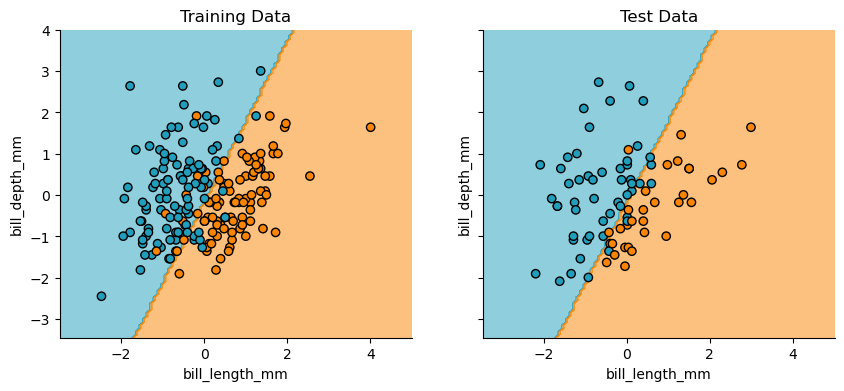

In [148]:

cmap = ListedColormap(sorted(penguins['color'].unique())) # convert our color palette to a matplotlib colormap object

# plotting functions to avoid repeating code

# plot decision boudnary
def get_decision_boundary(X, classifier, fig_panel):
    # this function returns a decision boundary display object, and we can specify the figure panel to plot it on
    return DecisionBoundaryDisplay.from_estimator(
        classifier, X, response_method="predict",
        xlabel=X.columns[0], ylabel=X.columns[1],
        alpha=0.5, cmap=cmap, ax=axs[fig_panel])

# add data points to the plot with decision boundary
def plot_decision_boundary_with_data(disp, X, Y):
    # this function takes a decision boundary display object, and plots it along with the data
    disp.ax_.scatter(X[X.columns[0]], X[X.columns[1]], c=penguins['color'].loc[Y.index], edgecolor="k")
    sns.despine()

# design the plot

# specify the layout
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# get the decision boundary objects to display
disp_train = get_decision_boundary(X_train, model_fit, fig_panel=0)
disp_test = get_decision_boundary(X_train, model_fit, fig_panel=1)

# plot decision boundary along with training and test data
plot_decision_boundary_with_data(disp_train, X_train, Y_train)
plot_decision_boundary_with_data(disp_test, X_test, Y_test)

# make titles
axs[0].set_title("Training Data")
axs[1].set_title("Test Data")


As you can see, the model made a decision boundary right between the data that are highly clustered by species.

Things get interesting on hard mode, where it's nice to have the model make a decision for us because it's not immediately obvious.



Lastly, how do each of the variables contribute to the prediction? What has our model learned?

In [149]:
# print the coefficients
print("Features: ", list(X_train.columns))
print("Coefficients: ", model_fit.coef_)
print("Intercept: ", model_fit.intercept_)


Features:  ['bill_length_mm', 'bill_depth_mm']
Coefficients:  [[ 2.5927907  -1.32716669]]
Intercept:  [-0.24260425]


The interpretation of these coefficients is the following:

**Positive**: as the value of that feature ***increases***, the response (log odds) ***increases***. Bill length is positive.

**Negative**: as the value of that feature ***increases***, the response (log odds) ***decreases***. Bill depth is negative.

**Magnitude**: how strongly each feature drives the value of the response (the log odds), because we've normalized all our features to be on the same scale, we can directly compare them!

We can also use this model to predict new hypothetical samples! Look at the decision boundary above, and select a pair of feature values, and see what the predicted species is to see if everything's working.


In [150]:
# input data has to be a 2D array, so instead of giving the .predict() function a list [] of features, we have to use a nested list [[]]
print( model_fit.predict([[2,-1]]) )

['Gentoo']


/Users/bjarnold/miniforge3/envs/datascience/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# Decision Tree classifier

Our accuracy is already incredibly good with the simplest ML classifier, which isn't too surprising given these data are also very simple. If the simplest model already has > 99% accuracy, there's little point in using more complex models.

However, to illustrate another extremely popular ML model that's more complex than logistic regression, let's make a decision tree to classify these penguin species.

Decision trees use a series of "if-then" rules to create a decision boundary, splitting feature space into regions that are as homogenous as possible in order to separate the species we're trying to classify. These 'if-then' rules can create more complicated decision boundaries than simple straight lines, which are made by logistic regression.

Lets train a decision tree classifier using our training data.

In lecture, I mentioned that decision trees have a hyperparameter that we specify beforehand: the number of splits we allow it to make. 

Let's allow the decision tree to make anywhere from 1 split (the fewest) to 30 splits (probably way too much, given simplicity of data).

In [151]:
# specify max number of splits
max_splits = 30
# make a list of all the number of splits we want to test, using the built-in range() python function
splits_to_make = range(1, max_splits + 1)

print(list(splits_to_make))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


We have our hyperparameter values stored in a list, let's iterate through them, training a decision tree each time.

We do this using a for loop, where we have some 'dummy' variable called `s` that takes on a different value stored in the `splits_to_make` list until we've gone through the entire list. You can experiment with for loops to see how they work if you don't already!

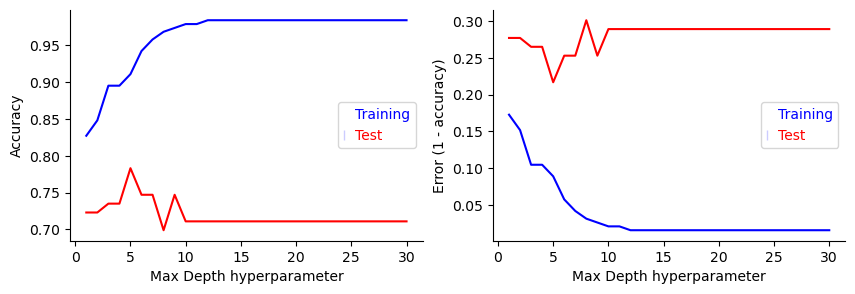

In [152]:
# initialize empty lists that will store scores for training and test data
scores_train = []
scores_test = []

# train a model for each number of splits, record the accuracy
for s in splits_to_make:
    #initialize tree classifier with hyperparameter max_depth = d
    T = DecisionTreeClassifier(max_depth = s, random_state = 11)
    # fit model with training data using scikit learn fit() function
    T.fit(X_train, Y_train)
    # get accuracy using scikit learn score() function
    train_accuracy = T.score(X_train, Y_train)
    test_accuracy = T.score(X_test, Y_test)
    # record the scores, the append() function adds the score to the end of the list
    scores_train.append( train_accuracy )
    scores_test.append( test_accuracy )

# convert to numpy array to enable vectorized math operations
scores_train = np.array(scores_train)
scores_test = np.array(scores_test)

# plot the results!!

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# plot the accuracy
sns.lineplot(x=splits_to_make, y = scores_train, color="blue", ax=axs[0])
sns.lineplot(x=splits_to_make, y = scores_test, color="red", ax=axs[0])
axs[0].set_xlabel("Max Depth hyperparameter")
axs[0].set_ylabel("Accuracy")

# plot the error, or 1 - accuracy
sns.lineplot(x=splits_to_make, y = 1 - scores_train, color="blue", ax=axs[1])
sns.lineplot(x=splits_to_make, y = 1 - scores_test, color="red", ax=axs[1])
axs[1].set_xlabel("Max Depth hyperparameter")
axs[1].set_ylabel("Error (1 - accuracy)")

# add a legend showing the color of each line
axs[0].legend( labels=["Training", "Test"], labelcolor=["blue", "red"], handlelength=0)
axs[1].legend( labels=["Training", "Test"], labelcolor=["blue", "red"], handlelength=0)


sns.despine()

These results look uninteresting because the data are simple, but when enabling hard mode they look much more interesting and familiar.

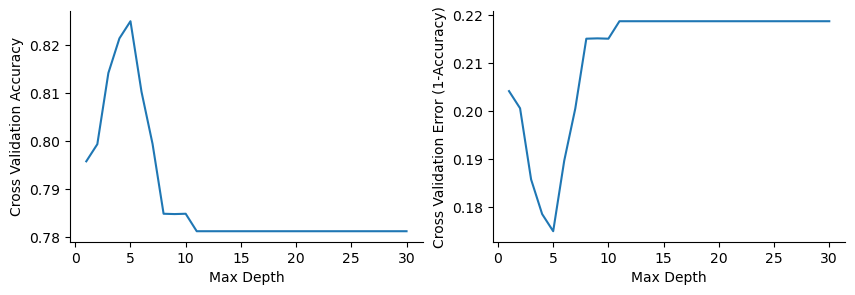

In [153]:
cv_scores = []

#Loop through depths from 1-30
for d in splits_to_make:
    #Decision Tree model with max_depth = d
    # we use a 'pipeline' from sci_kit learn to combine the scaler and the classifier model, 
    # so that it renormalizes our data each time it splits the data using the scaler we gave it
    model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth = d, random_state = 11))
    
    # generate indices to split data into train/test sets
    # note shuffle=True, this is important if your data table is structured by the response variable!
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

    # calculate cross validation scores for each model, 
    # note that we give it the entire dataset, not just the training data, and we also are calculating the mean in the same line
    cv_score_mean = cross_val_score(model, X, Y, cv = strat_k_fold).mean()

    # store cross validation score
    cv_scores.append( cv_score_mean )

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.lineplot(x=splits_to_make, y = cv_scores, ax=axs[0])
# plt.grid(axis='x', color='gray', linestyle='--', linewidth=1)
axs[0].set_xlabel("Max Depth")
axs[0].set_ylabel("Cross Validation Accuracy")

sns.lineplot(x=splits_to_make, y = 1 - np.array(cv_scores), ax=axs[1])
axs[1].set_xlabel("Max Depth")
axs[1].set_ylabel("Cross Validation Error (1-Accuracy)")
sns.despine()


In [154]:
#Decision Tree model with max_depth = best_depth chosen from cross validation
best_max_depth = 5
T = DecisionTreeClassifier(max_depth = best_max_depth, random_state = 11)
T.fit(X_train, Y_train)
print(T.score(X_train, Y_train))
print(T.score(X_test, Y_test))

0.9109947643979057
0.7831325301204819


As above, we can plot the decision boundary for the decision tree. You can change the `best_max_depth` value above from 1 to 3 to see how it changes for different hyperparameter values.

Text(0.5, 1.0, 'Test Data')

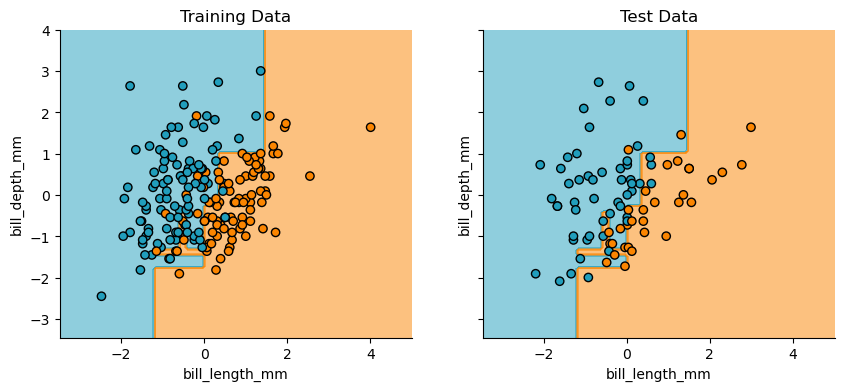

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# use the same function above, which we've made flexible enough to work with any classifier
# this avoids making redundant code, which leads to very long notebooks that are hard to read!
disp_train = get_decision_boundary(X_train, T, fig_panel=0)
disp_test = get_decision_boundary(X_train, T, fig_panel=1)

# plot decision boundary along with training and test data
plot_decision_boundary_with_data(disp_train, X_train, Y_train)
plot_decision_boundary_with_data(disp_test, X_test, Y_test)

# make titles
axs[0].set_title("Training Data")
axs[1].set_title("Test Data")


One of the many nice things about decision trees is the ability to calculate ***feature importance scores***. Let compute these to see how the decision tree classifier is using each of the two features: bill length and bill depth.

Text(0, 0.5, 'Feature Importance')

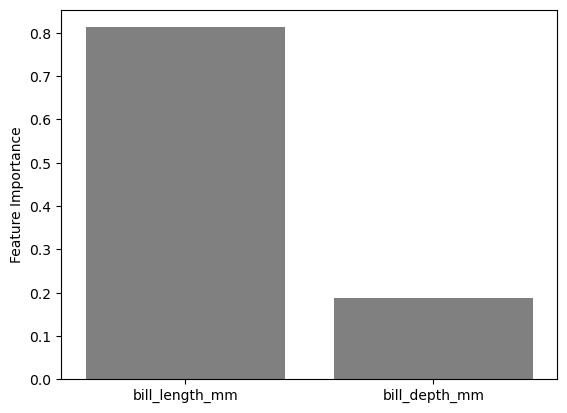

In [156]:
# make a barplot of feature importance
sns.barplot(x=list(X_train.columns), y=T.feature_importances_, color="gray")
plt.ylabel("Feature Importance")

Interesting, on easy mode, the decision tree classifier deems bill depth as much more important in distinguishing between species. Does this make sense? If we look at the splits the decision tree made in the plots above, do splits on the bill depth axis seem to be dividing the data into more homogenous groups?

If it thinks bill depth is so important, if we force the tree to only get to make 1 split (set `best_max_depth`=1), does it choose the bill depth feature?

We can also make visualize exactly how the decision tree splits the data and makes a final decision as to what species to predict.

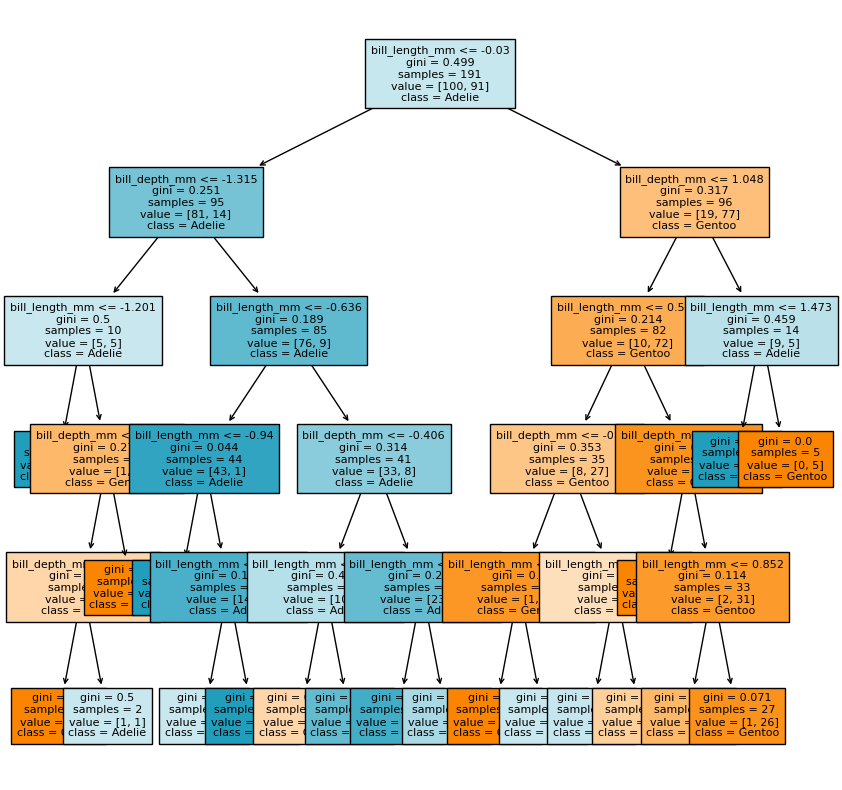

In [157]:
plt.figure(figsize=(10, 10))

artists = plot_tree(T, feature_names=X_train.columns, class_names=penguins['species'].unique(), filled=True, fontsize=8)

for artist, impurity, value in zip(artists, T.tree_.impurity, T.tree_.value):
    # let the max value decide the color; whiten the color depending on impurity (gini)
    r, g, b = to_rgb(pal[np.argmax(value)])
    f = impurity * (3/2) # for N colors: f = impurity * N/(N-1) if N>1 else 0
    artist.get_bbox_patch().set_facecolor((f + (1-f)*r, f + (1-f)*g, f + (1-f)*b))
    artist.get_bbox_patch().set_edgecolor('black')

We can use this model we've just trained to predict new data using the `predict()` function

In [158]:
print( T.predict([[-1, 0]]) )

['Adelie']


/Users/bjarnold/miniforge3/envs/datascience/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
